<a href="https://colab.research.google.com/github/TapasKumarDutta1/IEEE-CIS-Fraud/blob/master/autoenc_prep_without_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras.backend as K
from matplotlib import pyplot as plt
from tqdm import tqdm
from math import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, concatenate
from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import roc_auc_score
import gc
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras import backend as K
import pandas as pd
from keras.utils import Sequence
from google.colab import drive

Loading the drive

In [ ]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [ ]:

np.random.seed(42) # NumPy
random.seed(42) # Python

Loading data

In [ ]:

trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv',index_col=[0])

Drop id and isFraud

In [ ]:
trn=trn.drop(['isFraud','id'],1)
tst=tst.drop(['id'],1)

Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """
    Reduce memory usage of a DataFrame by converting data types to lower memory equivalents.

    Parameters:
        df (pandas.DataFrame): The DataFrame to be optimized.

    Returns:
        pandas.DataFrame: The DataFrame with optimized memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of the DataFrame is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


# Example usage
trn = reduce_mem_usage(trn)
tst = reduce_mem_usage(tst)

Memory usage of dataframe is 2243.72 MB
Memory usage after optimization is: 554.17 MB
Decreased by 75.3%
Memory usage of dataframe is 1925.14 MB
Memory usage after optimization is: 475.49 MB
Decreased by 75.3%


Concatenate data

In [ ]:
# Concatenate the DataFrames trn and tst into a new DataFrame X
X = pd.concat([trn, tst]).reset_index(drop=True)

# Delete the original DataFrames trn and tst to free up memory
del [trn, tst]

# Perform garbage collection to release memory used by deleted objects
gc.collect()

0

Divide data into categorical and numerical

In [ ]:
# Convert categorical columns to uint8 data type
cat = [str(i) for i in range(444)]
X[cat] = X[cat].astype("uint8")

# Find numeric columns that are not in the categorical columns
no_dum = [i for i in X.columns if i not in cat]

# Get the number of numeric and categorical features
num_shape = len(no_dum)
cat_shape = len(cat)

In [ ]:

def custom_gelu(x):
    """
    Custom gelu activation function.

    Parameters:
    x (tensor): Input tensor.

    Returns:
    tensor: Output tensor after applying custom gelu activation.
    """
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def create_model():
    """
    Create a neural network model with custom gelu activation.

    Returns:
    keras.models.Model: Neural network model with inputs and outputs.
    """
    # Collect garbage to free up memory
    gc.collect()

    # Clear any existing Keras session
    K.clear_session()

    # Define input layers for numeric and categorical features
    num_inp = Input(shape=(num_shape,))
    cat_inp = Input(shape=(cat_shape,))

    # Concatenate the numeric and categorical inputs
    inps = concatenate([num_inp, cat_inp])

    # Create dense layers with custom gelu activation
    x = Dense(512, activation=custom_gelu)(inps)
    x = Dense(256, activation=custom_gelu)(x)
    x = Dense(512, activation=custom_gelu)(x)

    # Add dropout layer for regularization
    x = Dropout(0.2)(x)

    # Output layers for numeric and categorical features
    cat_out = Dense(cat_shape, activation="linear")(x)
    num_out = Dense(num_shape, activation="linear")(x)

    # Create the model with inputs and outputs
    model = Model(inputs=[num_inp, cat_inp], outputs=[num_out, cat_out])

    # Compile the model with Adam optimizer and mse loss for both outputs
    model.compile(optimizer=Adam(0.05, clipnorm=1, clipvalue=1), loss=["mse", "mse"])

    return model

Warmup learning rate

In [ ]:

class WarmUpLearningRateScheduler(keras.callbacks.Callback):
    """
    Custom Callback to implement a warm-up learning rate scheduler.

    Parameters:
        warmup_batches (int): The number of batches for the warm-up phase.
        init_lr (float): The initial learning rate before warm-up.
        verbose (int): Whether to print messages about learning rate changes.

    Example:
        warmup_lr_scheduler = WarmUpLearningRateScheduler(warmup_batches=100, init_lr=0.01, verbose=1)
    """

    def __init__(self, warmup_batches, init_lr, verbose=0):
        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        """
        Callback function executed at the end of each batch.

        Parameters:
            batch (int): The current batch index.
            logs (dict): Dictionary containing the training metrics for the current batch.
        """
        self.batch_count += 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        """
        Callback function executed at the beginning of each batch.

        Parameters:
            batch (int): The current batch index.
            logs (dict): Dictionary containing the training metrics for the current batch.
        """
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count * self.init_lr / self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print("\nBatch %05d: WarmUpLearningRateScheduler setting learning rate to %s." % (self.batch_count + 1, lr))

Data generator for denoising autoencoder

In [ ]:
class DAESequence(Sequence):
    """
    Custom Sequence generator for Denoising Autoencoder (DAE) training.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the data for the DAE.
        no_dum (list): List of numerical column names.
        frac (float): Fraction of data to be corrupted (default is 0.15).
        dumm (range): Range of column indices for dummy/categorical columns (default is range(911)).
        batch_size (int): Batch size for training (default is 2048).

    Example:
        dae_seq = DAESequence(df, no_dum=['col1', 'col2', 'col3'], batch_size=1024)
    """

    def __init__(self, df, no_dum, frac=0.15, dumm=range(911), batch_size=2048):
        self.batch_size = batch_size
        self.frac = frac
        self.dumm = dumm
        self.df = df
        self.cat_data = df[dumm].values
        self.num_data = df[no_dum].values
        self.no_dumm = no_dum
        self.len_data = df.shape[0]
        self.columns = df.shape[1]
        self.data = df
        self.idx = []

    def __len__(self):
        """
        Returns the number of batches in the Sequence.

        Returns:
            int: The number of batches.
        """
        return int(ceil(self.len_data / self.batch_size))

    def __getitem__(self, idx):
        """
        Generates one batch of data for training.

        Parameters:
            idx (int): The index of the batch.

        Returns:
            tuple: A tuple containing input and output data for the DAE.
        """
        self.idx.append(idx)
        last = min((idx + 1) * self.batch_size, self.len_data)
        idx = idx * self.batch_size
        size = last - idx

        inps = []
        outs = []
        output_x = self.data.iloc[idx:last]

        # Generate noise for numerical columns
        data = output_x[self.no_dumm].values
        noise_x = data.copy()
        for i in range(len(self.no_dumm)):
            to = np.random.randint(0, size, int(size * self.frac))
            frm = np.random.randint(0, size, int(size * self.frac))
            noise_x[to, i] = noise_x[frm, i]

        inps.append(noise_x)
        outs.append(data)

        # Generate noise for categorical columns
        data = output_x[self.dumm].values
        noise_x = data.copy()
        for i in range(len(self.dumm)):
            to = np.random.randint(0, size, int(size * self.frac))
            frm = np.random.randint(0, size, int(size * self.frac))
            noise_x[to, i] = noise_x[frm, i]

        inps.append(noise_x)
        outs.append(data)

        return inps, outs

Fill nan by mean then by 0

In [ ]:
# Fill missing values with the column mean for columns with missing values
a = X.isna().sum()
a = a[a > 0]
cls = list(X)
for col in tqdm(list(a.index)):
    if col in cls:
        X[col] = X[col].fillna(X[col].mean())

# Fill remaining missing values with 0 for columns with missing values
a = X.isna().sum()
a = a[a > 0]
cls = list(X)
for col in tqdm(list(a.index)):
    if col in cls:
        X[col] = X[col].fillna(0)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [ ]:
# Create the model
model_mse = create_model()

# Initialize the learning rate warm-up scheduler
warm_up_lr = WarmUpLearningRateScheduler(warmup_batches=400, init_lr=0.0005)

# Free up memory
gc.collect()

# Define the number of epochs and batch size
epochs = 100
batch_size = 2048

# Create the data generator using DAESequence
train_gen = DAESequence(X, no_dum, batch_size=batch_size, dumm=cat)

# Train the model
hist = model_mse.fit_generator(
    train_gen,
    steps_per_epoch=len(X) // batch_size,
    epochs=epochs,
    verbose=1,
    workers=-1,
    use_multiprocessing=True,
    callbacks=[warm_up_lr],
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
535/535 [==============================] - 23s 43ms/step - loss: 0.2237 - dense_4_loss: 0.1960 - dense_3_loss: 0.0277
Epoch 2/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0842 - dense_4_loss: 0.0711 - dense_3_loss: 0.0131
Epoch 3/50
535/535 [==============================] - 23s 44ms/step - loss: 0.0748 - dense_4_loss: 0.0643 - dense_3_loss: 0.0105
Epoch 4/50
535/535 [==============================] - 23s 44ms/step - loss: 0.0680 - dense_4_loss: 0.0585 - dense_3_loss: 0.0095
Epoch 5/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0643 - dense_4_loss: 0.0553 - dense_3_loss: 0.0090
Epoch 6/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0644 - dense_4_loss: 0.0557 - dense_3_loss: 0.0087
Epoch 7/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0603 - dense_4_loss: 0.0519 - dense_3_loss: 0.0084
Epoch 8/50
535/535 [=

In [ ]:
mod=Model(inputs=model_mse.inputs,outputs=model_mse.layers[4].output)
mod.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 53)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 444)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 497)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          254976      concatenate[0][0]     

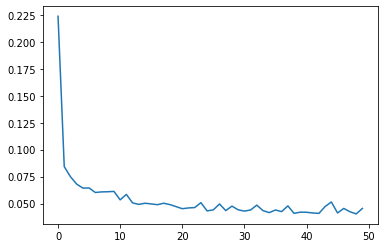

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
pre=mod.predict([X[no_dum],X[cat]])
pre.shape

(1097231, 256)

In [ ]:
pd.DataFrame(pre).to_csv('/content/gdrive/My Drive/fraud/without_id.csv')